# DeepChem 라이브러리를 활용한Solubility Modeling

* python==3.6
* deepchem==2.4.0
* Rdkit==1.16
* tensorflow==1.14

Install deepchem library

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  16619      0 --:--:-- --:--:-- --:--:-- 16619


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [ ]:
!pip install --pre deepchem

     |████████████████████████████████| 409kB 4.5MB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20201104023843-cp36-none-any.whl size=510651 sha256=1241cdc1b40361300c5cb716654183cbede04cac4701abd4c523ffd57300dd59
  Stored in directory: /root/.cache/pip/wheels/c0/8b/61/a7a958da7d3b6584ea65555a6b97bc9e1a811153834001f100
Successfully built deepchem


Install RDkit

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge python=3.6
!time conda install -q -y -c conda-forge rdkit

--2020-11-04 02:38:46--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-11-04 02:38:46--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / done

## Package Plan ##

  environment location: /usr/local

  added / upda

In [ ]:
import deepchem as dc
dc.__version__

'2.4.0-rc1.dev'

In [ ]:
!python --version

Python 3.6.10 :: Anaconda, Inc.


# Modeling Solubility


분자 용해도를 계산하여 예측하는 것은 약물 발견에 유용합니다. 약물과 유사한 화합물의 용해도를 예측하는 모델을 구축하는데 `deepchem` 라이브러리를 사용합니다. 모델에 fitting하는 과정에는 4단계가 있습니다.

1. 수성 용해도 측정과 함께 일련의 화합물로 구성된 화학 **데이터세트 로드**
2. 각 화합물을 통계 학습 방법이 이해할 수 있는 **특징 벡터**($v \in \mathbb{R}^n$)**로 변환**
3. 특징 벡터를 수용성 용해도의 추정치에 매핑하는 **간단한 모델 학습**
4. 결과 **시각화**

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
#필요한 라이브러리 import 과정 
from rdkit import Chem
#rdkit으로 얻은 mol object를 시각화하기위한 라이브러리와 노트북에 시각화하는 메소드가 담긴 라이브러리 
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
#Mol object에 기반하여 표현자를 만들어 주는 메소드가 담긴 라이브러리
from rdkit.Chem import Descriptors
#이하 데이터로드 및 여러가지 메소드가 담긴 라이브러리이며 필요에 의해 import를 하여 사용하면된다.
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np


## 1. Load to data

우리는 추정된 수용성 용해도 측정 데이터 세트[1]를 Deepchem에 로드해야합니다. 데이터는 csv 형식이고 SMILES 문자열, 예측된 수성 용해도 및 많은 분자특성을 포함합니다. 데이터 세트 예제는 다음과 같습니다.

<table style="width:100%">
  <tr>
    <th> Compound ID </th>
    <th> ESOL predicted log solubility (mols/liter) </th> 
      <th> Minimum Degree </th> 
      <th> Molecular Weight </th>
      <th> # H-Bond Donors </th>
      <th> # Rings </th>
      <th> # Rotatable Bonds </th>
      <th> Polar Surface Area </th>
      <th> Measured log solubility (mols/liter) </th>
      <th> smiles </th>
  </tr>
  <tr>
    <td>benzothiazole</td>
    <td>-2.733</td> 
    <td>2</td>
      <td> 135.191 </td>
      <td> 0 </td>
      <td> 2 </td>
      <td> 0 </td>
      <td> 12.89 </td>
      <td> -1.5 </td>
      <td> c2ccc1scnc1c2 </td> 
  </tr>

</table>


이 필드의 대부분은 우리의 목적에 유용하지 않습니다. 우리가 필요로하는 두가지 속성은 `SMILEs` 와 `Measured log-solubility in mols/liter`입니다. 데이터를 `Deepchem`에 로드하기 전에 데이터를 `python`에 로드하고 간단한 예비 분석을 수행하여 데이터에 대한 이해를 해봅시다.

In [ ]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
#!wget -O delaney-processed.csv https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
#!wget -P /want/directory https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2020-11-04 02:40:17--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.01s   

2020-11-04 02:40:17 (6.22 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [ ]:
#데이터가 잘 다운로드되었는지 확인
!ls

conda_installer.py     Miniconda3-latest-Linux-x86_64.sh  sample_data
delaney-processed.csv  __pycache__


In [ ]:
#pandas read.csv와 같은 역할을 수행하는 라이브러리
from deepchem.utils.save import load_from_disk  

dataset_file= "delaney-processed.csv"
dataset = load_from_disk(dataset_file)
print("Columns of dataset: %s" % str(dataset.columns.values))
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

deepchem.utils.save has been deprecated.
The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.


Columns of dataset: ['Compound ID' 'ESOL predicted log solubility in mols per litre'
 'Minimum Degree' 'Molecular Weight' 'Number of H-Bond Donors'
 'Number of Rings' 'Number of Rotatable Bonds' 'Polar Surface Area'
 'measured log solubility in mols per litre' 'smiles']
Number of examples in dataset: 1128


In [ ]:
print(type(dataset))
dataset

<class 'pandas.core.frame.DataFrame'>


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


## 2. Data EDA

데이터 세트에서 화합물을 시각적으로 이해하려면 RDkit을 사용하여 화합물을 그려 봅시다.

우선 이미지로 출력하기 위한 함수를 정의가 아래 코드에 있습니다.

In [ ]:
import tempfile
from itertools import islice
from IPython.display import Image, display
"""
이미지로 출력하기 위한 함수로 입력을 파일이름 리스트를 받고, 
파일이름 리스트에서 파일이름을 얻어와서 이미지타입으로 변경 후 display해주는 함수
"""
def display_images(filenames):
    for file in filenames:
      display(Image(file))
"""
Mol Object를 png(이미지 파일 포맷)으로 변환하는 함수로, 
Mol Object list를 입력으로 주면 해당 리스트의 Mol Object를 얻어와서
아래의 경우 5개의 이미지를 출력한다고 하면 
test0.png, test1.png, test2.png, test3.png, test4.png의 파일을 생성하고
파일에 Mol Object를 그려준다.
그 파일들을 filenames라는 리스트에 모두 넣어주고 그 결과를 출력해준다.
"""
def mols_to_pngs(mols, basename="test"):
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

입력 받은 데이터의 분자를 시각화해봅시다.

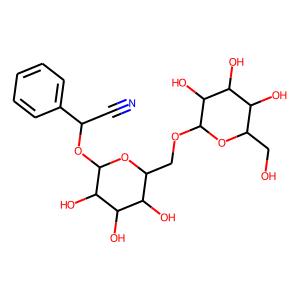

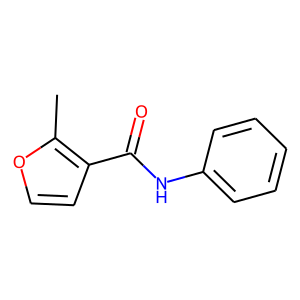

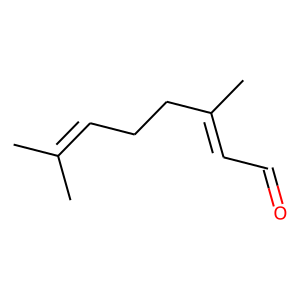

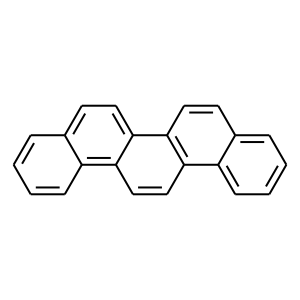

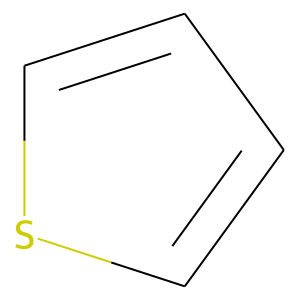

In [ ]:
num_to_display = 5
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["smiles"]))
display_images(mols_to_pngs(molecules))

In [ ]:
mols_to_pngs(molecules)

['test0.png', 'test1.png', 'test2.png', 'test3.png', 'test4.png']

입력 받은 데이터의 타겟변수 `logS` 분포를 살펴봅시다. 내가 사용하고자하는 함수의 기능이나 인자를 살펴보기위해서는 인터넷에 패키지명과 함수명으로 검색을 수행하거나, 코드 작업 중인 창에서 함수명 뒤에 커서를 올려놓고 기다리면 함수 `doc`을 볼 수 있습니다.

In [ ]:
dataset

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


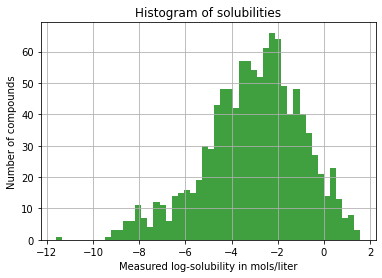

In [ ]:
#colab의 경우 마지막 실행 결과를 출력하게 기본 세팅이 되어있으나 로컬이나 주피터 노트북에서는 아래의 명령어를 주어야 그래프가 나타남
%matplotlib inline
#그래프를 그리기위한 라이브러리 import
import matplotlib
#파이썬에서 배열 데이터를 다루기 위한 라이브러리 일반적으로 np 라는 별칭 사용
import numpy as np
#파이썬에서 시각화를 담당하는 라이브러리 일반적으로 plt라는 별칭 사용
import matplotlib.pyplot as plt

#데이터프레임에서 원하는 열을 필터링하여 np.array로 변환
#함수의 입력으로 np.array 타입을 원하기에 아래와 같이 변환
#단일 변수를 입력으로 주어 빈도 그래프를 출력하기 위함
solubilities = np.array(dataset["measured log solubility in mols per litre"])
#히스토그램을 그리기 위한 함수 사용 
#인터넷에 패키지 이름과 함수명으로 검색하면 아래와 같은 doc을 찾을 수 있음
# https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(solubilities, 50, facecolor='green', alpha=0.75)
#출력할 그래프의 x축 y축 이름을 설정하는 부분
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
#그래프의 제목
plt.title('Histogram of solubilities')
#격자 무늬 출력
plt.grid(True)
#그래프 출력 명령어
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


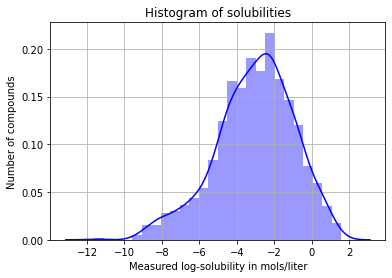

In [ ]:
#matplotlib 라이브러리 보다 다양한 기능을 지원하는 seaborn 라이브러리 사용
import seaborn as sns

#데이터프레임에서 원하는 열을 필터링하여 np.array로 변환
#함수의 입력으로 np.array 타입을 원하기에 아래와 같이 변환
#단일 변수를 입력으로 주어 빈도 그래프를 출력하기 위함
solubilities = np.array(dataset["measured log solubility in mols per litre"])
#히스토그램을 그리기 위한 함수 사용 kde옵션에 True를 주면 선 그래프를 추가해줌
sns.distplot(solubilities, color="blue", kde=True)
#출력할 그래프의 x축 y축 이름을 설정하는 부분
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
#그래프의 제목
plt.title('Histogram of solubilities')
#격자 무늬 출력
plt.grid(True)
#그래프 출력 명령어
plt.show()

## 데이터 변환(Transform)

 사전 분석이 완료되면,  `deepChem`라이브러리를 사용하여 분자 용해도의 예측 모델을 구성합니다. 이러한 분자를 생성하는 첫 번째 단게는 각 화합물을 통계적 학습 기술로 이해할 수 있는 벡터 형식으로 변환하는 것입니다. 이러한 과정을 일반적으로 `featurization`(특성화)라고 합니다.

대부분의 얻을 수 있는 데이터에는 분자구조 정보가 `SMILES`형식으로 되어있습니다. 이에 대한 특성 벡터를 생성하는 방법으로 `ECPF`를 사용합니다.\[3\] `deepChem`은 특성화를 위한 `API`를 제공하고 이는 `dc.feat`.하위에 대부분 존재합니다. 아래 코드의 순서는 다음과 같습니다.

1. 특성화를 시작하기 위해 먼저 특성화 객체를 생성합니다. `deepChem`은 `CircularFingerprint` 클래스(ECFP 특성화를 수행하는 `Featurizer`의 하위 클래스)를 제공합니다.
2. 데이터를 불러오고 불러온 데이터에 특성화 작업을 수행합니다.

In [ ]:
import deepchem as dc
"""
deepchem의 feat에는 다양한 featurizer가 존재함 
그 중 우리가 사용할 ECFP 특성화에는 CircularFingerprint를 사용하면 됨
"""
featurizer = dc.feat.CircularFingerprint(size=1024)

이제 실제 특성화를 수행해봅시다. deepchem은 이러한 목적으로 CSVLoader 클래스를 지원합니다. 이 클래스의 featurize()메서드는 디스크에서 데이터를 로드하고 제공된 'Featurizer' 인스턴스를 사용하여 제공된 데이터를 특징 벡터로 변환합니다.

이러한 데이터 세트에 대해 기계학습을 수행하려면 샘플을 기계 학습에 적합한 데이터세트로 변환해야합니다.(즉, 데이터 행렬 $X \in \mathbb{R}^{n\times d}$, 여기서 $n$은 샘플 수를 $d$는 특징 벡터의 차원을 레이블 벡터는 다음과 같이 표현합니다. $y \in \mathbb{R}^n$)

In [ ]:
#첫번째 인자는 해당 SMILES의 Label로 사용할 열의 이름
#두번째 인자는 변환할 SMILES 데이터가 존재하는 열의 이름
#세번째 인자는 앞서 생성한 Featurizer 객체
loader = dc.data.CSVLoader(
      tasks=["measured log solubility in mols per litre"], smiles_field="smiles",
      featurizer=featurizer)
#dataset_file = "delaney_processed.csv"를 말함
dataset = loader.featurize(dataset_file)

smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
/usr/local/lib/python3.6/dist-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


In [ ]:
print(dataset.X[0], dataset.y[0])
print(len(dataset.X[0]), len(dataset.y[0]))

[0. 1. 0. ... 0. 0. 0.] [-0.77]
1024 1


출력을 해보면 우리가 처음에 사용했던 것과 다른 모양으로 데이터가 생성된 것을 확인할 수 있다.

이는 deepchem 라이브러리에 포함된 여러 알고리즘으로 학습을 수행할때 아래와 같은 형식을 원하기 때문이다.

##4. 데이터 분할

모델을 구성할 때는 제공된 데이터를 Training/Test subset으로 분리해야합니다.

Training set은 모델을 학습하는데 사용되고 Test set은 학습된 모델을 평가하는데 사용됩니다.

실제로 모델 학습에는 그림 하단부와 같이 Training, Validation, Test split을 수행하는 것이 대체로 유용합니다. 

모델의 학습과 학습과 동시에 모델 성능 평가의 에는 Training set과 Validation set을 사용합니다. Testset은 주어진 데이터에서 Split하고, 어떤 데이터인지 우리는 알고 있지만, 학습하는 모델이 모르게 해야합니다.




In [ ]:
#dc.splits에서 다양한 분할 방법을 제공
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)

정말로 train과 test split의 분자 구성이 다른지 살펴봅시다.

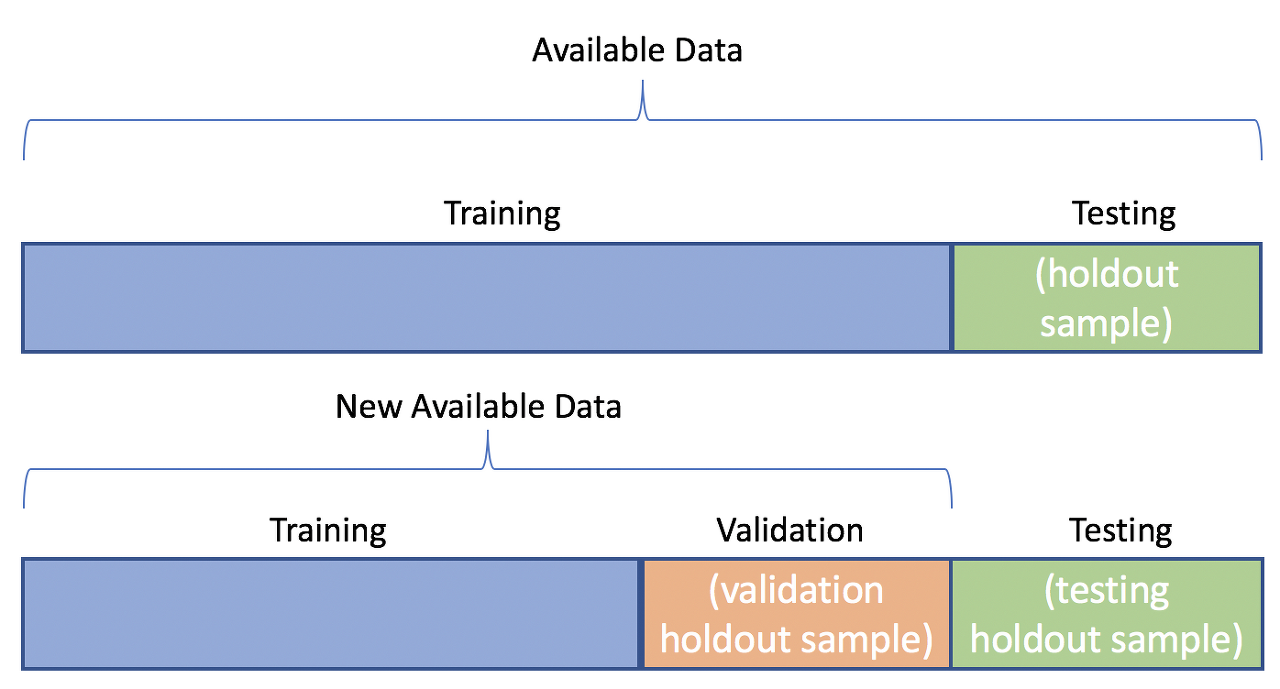

훈련, 검증, 테스트 분할을 수행하는 적절한 방법을 선택하는 것은 어려울 수 있습니다.

 기계학습 모델의 입력 데이터 분할 시 데이터를 Train/Validation/Test로 Random split하는 것이 일반적 입니다. 하지만, 무작위 분할은 화학 정보학의 목적에 알맞지 않습니다.

예측 모델이 유용하기 위해서는 훈련 데이터의 분자 세트를 넘어서 화학 공간의 일부에 예측력이 있어야 합니다.

결론적으로, 데이터 분할 과정에서 Bemis-Murcko Scaffolds를 사용하여 이 분할을 수행합니다. 기본 분자 구조(scaffolds)를 공유하는 모든 화합물은 Train/Validation/Test split에서 동일한 분할 위치에 배치됩니다. 꼭 Scaffolds Split이 유용한 것은 아니지만 이번에는 Scaffolds Split을 사용합니다.

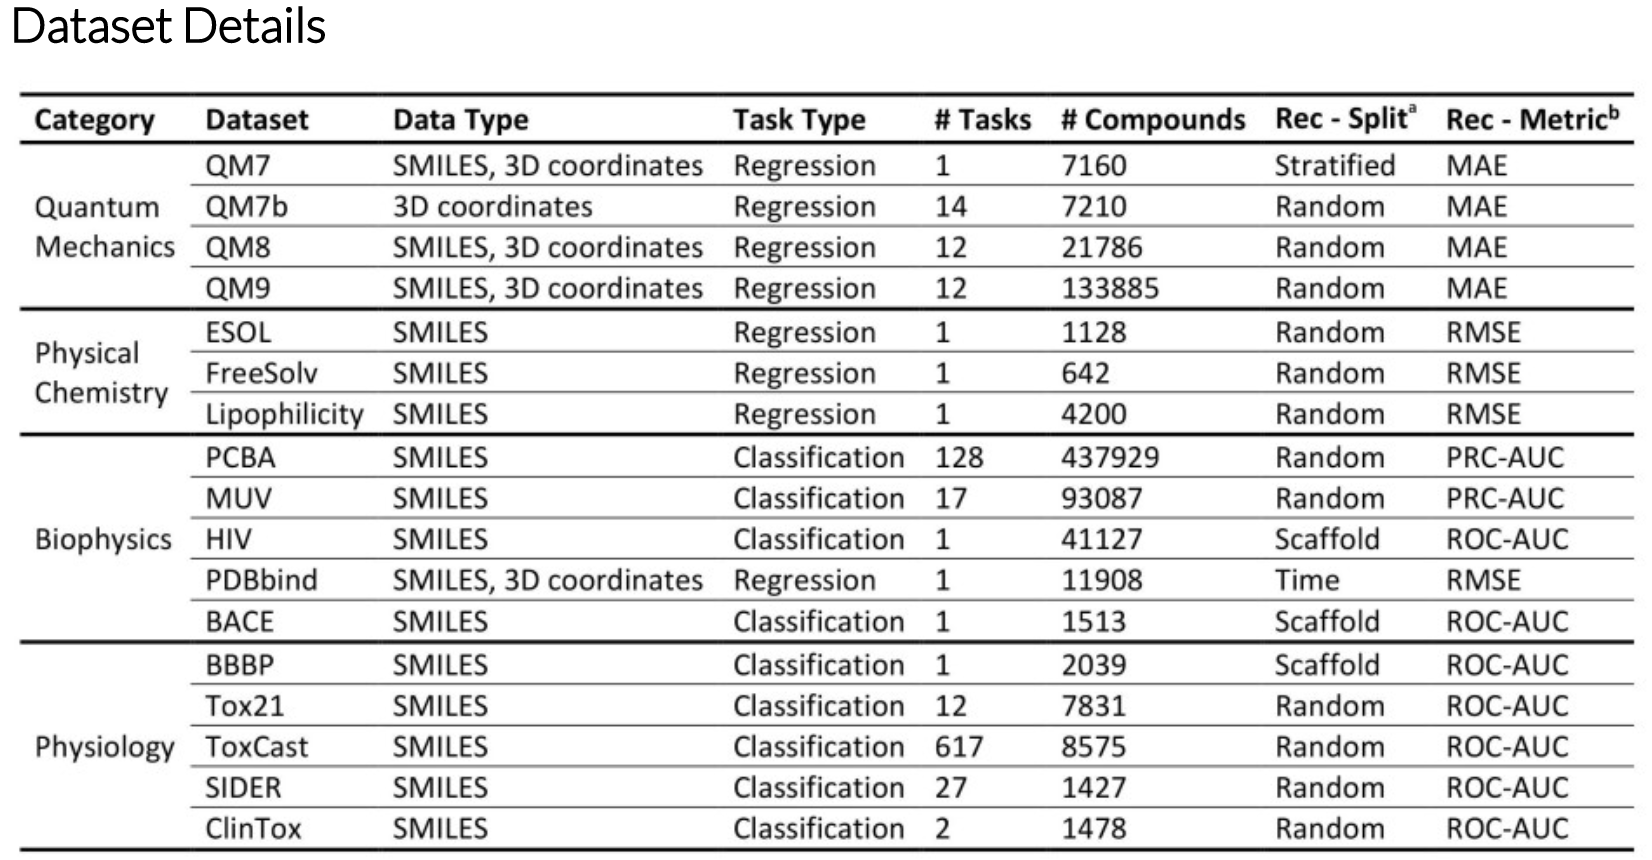

In [ ]:
train_dataset.ids[:5]

array(['CC(C)=CCCC(C)=CC(=O)', 'CCCC=C', 'CCCCCCCCCCCCCC', 'CC(C)Cl',
       'CCC(C)CO'], dtype=object)

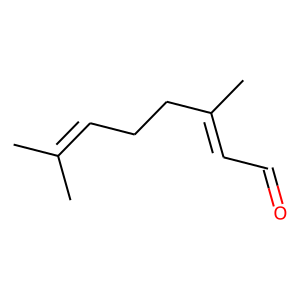

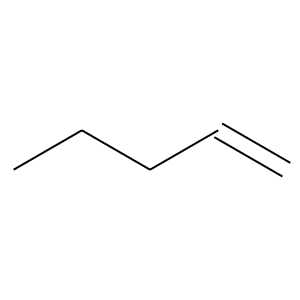

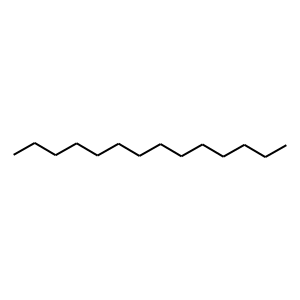

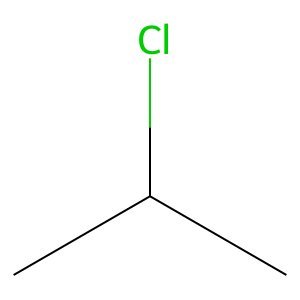

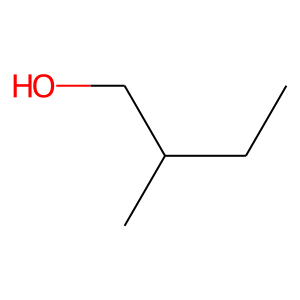

In [ ]:
#앞서 사용한 시각화 함수를 사용하여 Train/Test set의 Mol object의 차이점 확인
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_dataset.ids]
display_images(mols_to_pngs(train_mols[:5], basename="train"))


In [ ]:
test_dataset.ids[:5]

array(['c1cc2ccc3cccc4ccc(c1)c2c34', 'Cc1cc(=O)[nH]c(=S)[nH]1',
       'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 ',
       'c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45', 'C1=Cc2cccc3cccc1c23'],
      dtype=object)

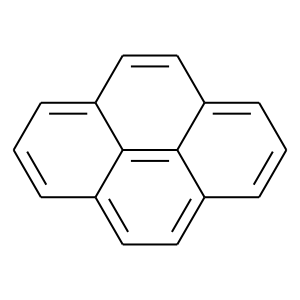

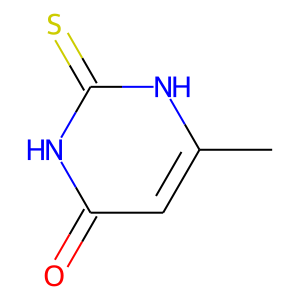

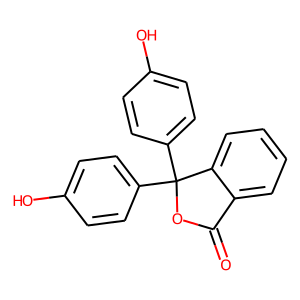

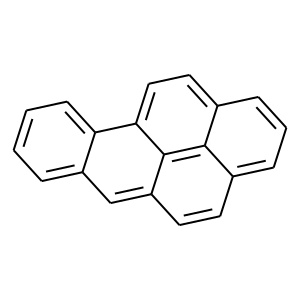

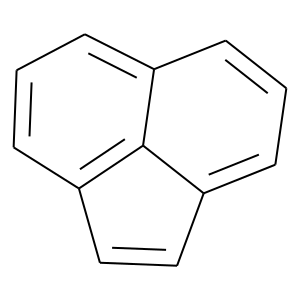

In [ ]:
test_mols = [Chem.MolFromSmiles(compound)
              for compound in test_dataset.ids]
display_images(mols_to_pngs(test_mols[:5], basename="test"))

가장 일반적인 `scaffolds`가 훈련 데이터에 저장되고, 드문 `scaffolds`는 검증과 테스트 데이터에 저장됩니다.

기계학습 알고리즘의 성능은 데이터의 전처리에 매우 민감할 수 있습니다. 

데이터에 적용되는 일반적인 변환 중 하나는 데이터를 평균화하고 단위 표준 편차를 갖도록 정규화하는 것입니다. 이 변환을 로그 용해도에 적용합니다.(-12\~2까지의 로그 용해도 분포에 적용)

정규화(normalization)는 다음과 같은 공식을 사용해서 특성 값의 범위를 \[0, 1\]로 옮깁니다. 이 공식을 사용하면 한 특성 내에 가장 큰 값은 1로, 가장 작은 값은 0으로 변환됩니다. 이 공식을 이용해서 각 특성들의 값을 변환해주면 모두 \[0, 1\]의 범위를 갖게 됩니다. 이제야 특성들이 평등한 위치에 놓여진 것입니다. 

$$
정규화 공식=X^
′=\frac{X-X_{min}}{X_{max}-X_{min}}
$$
$$
표준화공식 = X'= \frac{X-\mu}{\sigma}
$$
반면, 표준화(standardization)는 다음과 같은 공식으로 특성들의 값을 변환해 줍니다.  

여기서 μ는 한 특성의 평균값이고, σ는 표준 편차 입니다.  표준화는 어떤 특성의 값들이 정규분포, 즉 종모양의 분포를 따른다고 가정하고 값들을 0의 평균, 1의 표준편차를 갖도록 변환해주는 것입니다. 표준화를 해주면 정규화처럼 특성값의 범위가 0과 1의 범위로 균일하게 바뀌지는 않습니다.

In [ ]:
#데이터 표준화 과정 수행
transformers = [
dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

데이터 처리 후 다음 단계는 간단한 학습 모델을 데이터에 `fitting`해보는 것입니다. `deepchem`은 많은 기계 학습 모델 클래스를 제공합니다. 특히, `deepChem`은 `SklearnModel`에서 사용할 수 있는 모든 기계 학습 모델을 포함하는 편리한 클래스인 `scikit-learn`을 제공합니다.

결과적으로 계산된 ECFP4 특징에서 로그 용해도를 예측하는 간단한 랜덤 포레스트 회귀 분석을 시작할 수 있습니다. 모델을 훈련시키기 위해 `SklearnModel` 객체를 인스턴스화 한 다음 위에서 구축한 `train_dataset`에서 `fit()` 메서드를 호출합니다. 그런 다음 모델을 디스크에 저장합니다.

## DeepChem 라이브러리를 이용한 머신러닝 모델 학습(RandomForest)

In [ ]:
#sklearn 라이브러리에 포함된 RandomForestRegressor 모델 사용
#Sklearn는 머신러닝, 통계학과 관련되어 많은 기능들을 포함하고 있는 라이브러리로 
#python에서 데이터 분석할때 numpy, pandas 다음으로 가장 많이 사용되는 라이브러리이다.
from sklearn.ensemble import RandomForestRegressor

#모델이름과 인자를 입력으로 줌
sklearn_model = RandomForestRegressor(n_estimators=100)
#생성한 sklearn 모델을 deepchem models로 변경하는 코드
model = dc.models.SklearnModel(sklearn_model)
#train_dataset에 포함된 X, w, y값을 입력으로 모델 훈련
model.fit(train_dataset)

다음으로 검증 세트에서 모델을 평가하여 예측력을 확인합니다.
`deepchem`은 프로세스를 용이하게 하기 위해 평가자 클래스인 `Evaluator`을 제공합니다. 생성된 모델 객체를 평가하려면, 새로운 `Evaluator` 인스턴스를 만들고 `compute_model_performance()`를 호출합니다.

회귀 모델의 평가 metric에는 r2_score나 rms_score를 사용한다.
r2_score는 통계학에서 선형 회귀 모델에서 결정계수라고 하는 개념이며, 주어진 데이터들에 기반해 만들어진 선형 또는 회귀 모델이 주어진 데이터들을 얼마나 잘 '설명하는가'에 대한 수치입니다. r2이 1에 가까울 수록 주어진 데이터를 그대로 표현한다고 말합니다.

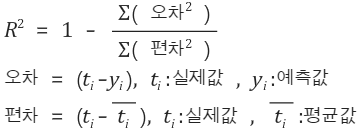

실제 값의 분산 대비 예측값의 분산 비율' 로 요약 될 수 있으며, 예측 모델과 실제 모델이 얼마나 강한 상관관계(Correlated)를 가지는가로 설명력을 요약할 수 있습니다.


rms_score는 평균 제곱근 오차(Root Mean Square Error; RMSE)는 추정 값 또는 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이를 다룰 때 흔히 사용하는 metric입니다.
수식은 간단하게 아래 그림처럼 나타낼 수 있습니다.



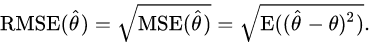

In [ ]:
#모델에 주어진 데이터셋을 입력으로 성능평가하는 클래스 Evaluator
from deepchem.utils.evaluate import Evaluator

#Evaluator로 평가하기위한 metric 생성
#r2을 선택하여 metric객체로 만들어줌
metric = dc.metrics.Metric(dc.metrics.r2_score)

#사용할 모델, 데이터, 데이터 변환방법을 인자로 Evaluator 객체를 생성
evaluator = Evaluator(model, valid_dataset, transformers)
#R2 score는 통계학에서는 결정계수라고 불리는데, 통계학 분야에서 의미하는 바와 같음
#주어진 데이터의 분포(정확히 말하면 분산)를 학습한 모델이 잘 나타내고 있는지 점수 [0,1]

#성능평가 점수를 출력하기 위한 compute_model_performance함수 인자로 사용할 metric 입력으로 줌
r2score = evaluator.compute_model_performance(metric)
print(r2score)


{'r2_score': 0.14659711131756015}


In [ ]:
from deepchem.utils.evaluate import Evaluator
#위와 동일한 코드이나 metric을 RMS를 사용함(Root Mean Squared) 높을 수록 좋지 않음
metric = dc.metrics.Metric(dc.metrics.rms_score)
evaluator = Evaluator(model, valid_dataset, transformers)
rmsScore = evaluator.compute_model_performance([metric])
print(rmsScore)

{'rms_score': 3.7742459085686058}


기본 랜덤포레스트 회귀 모델은 성능이 매우 좋지 않습니다. 

좋은 모델을 구성하기 위해 하이퍼파라미터를 최적화 해봅시다.(모델 사양에서 선택한 항목) 랜덤포레스트에서는 트리 수를 제어하는 `n_estimators`과 트리 분할을 수행할 때 고려할 특징의 수를 제어하는 `max_features`를 하이퍼파라미터로 사용합니다. 

이제 `n_estimators`와 `max_features`를 다르게 선택할 수 있는 리스트를 만들고, 일련의 `SklearnModel`을 빌드하고 유효성 검사 세트의 성능을 평가해 봅시다.

In [ ]:
#하이퍼파라미터를 최적화하기 위한 함수 rf_model_builder 생성

#model_dir은 dc.models.SklearnModel 함수의 인자로 
#다른 디렉토리에 생성한 모델이 있는 경우에 불러올 수 있도록 고정적으로 주어진 인자임
def rf_model_builder(n_estimators, max_features, max_depth, model_dir):
  sklearn_model = RandomForestRegressor(
      n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
  return dc.models.SklearnModel(sklearn_model, model_dir)

#하이퍼파라미터의 여러개의 값 설정 
params_dict = {
    "n_estimators": [10, 100],
    "max_features": ["auto", "sqrt", "log2", None],
    "max_depth" : [10,100, 200]
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
#dc.hyper.GridHyperparamOpt를 사용하여 하이퍼 파라미터 최적화
#함수 안에는 위에서 정의한 rf_model_builder를 인자로 줌
optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)
#dc.hyper.GridHyperparamOpt.hyperparam_search메서드에 
#인자로는 파라미터 사전, 훈련 데이터세트, 검증 데이터세트, 변환방법, 성능측정방법을 인자로 줌
#최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 변수에 담음
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, metric, transformers)

In [ ]:
#최고 성능을 보이는 모델 하이퍼파라미터 출력
print(best_rf)
#탐색할때 사용한 하이퍼파라미터의 최적 값 출력
print(best_rf_hyperparams)
#모든 탐색 성능 평가 결과 출력
print(all_rf_results)

SklearnModel(model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=200,
                                         max_features='sqrt',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=100, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             model_dir='/tmp/tmp3_c6vtwb')
(100, 'sqrt', 200)
{'_max_depth_10_max_featuresauto_n_estimators_10': 0.06177465949886618, '_max_depth_100_max_featuresaut

최고의 모델은 우리가 구축 한 첫 번째 모델보다 검증 세트에서 높은 $R^2$를 달성합니다.

하이퍼 파라미터 검색을 수행하지만 간단한 딥 네트워크를 사용합니다.

## DeepChem 라이브러리를 이용한 머신러닝 모델 학습(DNN)

In [ ]:
train_dataset.get_data_shape()[0]

1024

In [ ]:
import numpy.random
#ANN(Artificial Neural Network)이기 때문에 하이퍼파라미터가 다름
params_dict = {"learning_rate": [10**-5, 10**-4],
               "decay": [0.1],
               "nb_epoch": [20,50]}
#n_features가 필요한 이유는 모델 학습 시 입력 크기를 줘야하기 때문
#fp변환으로 크기는 1024임
n_features = train_dataset.get_data_shape()[0]
#하이퍼파라미터 검색을 위한 model_builder 함수 생성
# https://arxiv.org/pdf/1603.05027.pdf
def model_builder(learning_rate, decay, nb_epoch, model_dir):
  model = dc.models.MultitaskRegressor(
    1, n_features, layer_sizes=[1000], dropouts=[.25],
    batch_size=50, learning_rate=learning_rate, decay=decay, 
    nb_epoch=nb_epoch, model_dir=model_dir)
  return model
#dc.hyper.GridHyperparamOpt.hyperparam_search메서드에 
#인자로는 파라미터 사전, 훈련 데이터세트, 검증 데이터세트, 변환방법, 성능측정방법을 인자로 줌
#최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 변수에 담음
optimizer = dc.hyper.GridHyperparamOpt(model_builder)
best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, metric, transformers)

In [ ]:
params_dict

{'decay': [0.1], 'learning_rate': [1e-05, 0.0001], 'nb_epoch': [20, 50]}

In [ ]:
#최고 성능을 보이는 모델 하이퍼파라미터 출력
print(best_dnn)
#탐색할때 사용한 하이퍼파라미터의 최적 값 출력
print(best_dnn_hyperparams) 
#모든 탐색 성능 평가 결과 출력
print(all_dnn_results)

MultitaskRegressor(activation_fns=None, bias_init_consts=None, dropouts=None,
                   layer_sizes=None, n_features=1024, n_tasks=1, residual=None,
                   uncertainty=None, weight_decay_penalty=None,
                   weight_decay_penalty_type=None, weight_init_stddevs=None)
(0.0001, 0.1, 50)
{'_decay_0.100000_learning_rate_0.000010_nb_epoch_20': -2.1350921109857794, '_decay_0.100000_learning_rate_0.000010_nb_epoch_50': -1.5667594706257342, '_decay_0.100000_learning_rate_0.000100_nb_epoch_20': 0.09850010645400309, '_decay_0.100000_learning_rate_0.000100_nb_epoch_50': 0.12901159396640427}


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


이제 하이퍼 파라미터를 적절히 선택 했으므로 테스트 세트에서 최상의 모델의 성능을 평가 해 보겠습니다.

In [ ]:
rf_test_evaluator = Evaluator(best_rf, test_dataset, transformers)
rf_test_r2score = rf_test_evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (rf_test_r2score["r2_score"]))

RF Test set R^2 0.389085


In [ ]:
dnn_test_evaluator = Evaluator(best_dnn, test_dataset, transformers)
dnn_test_r2score = dnn_test_evaluator.compute_model_performance([metric])
print("DNN Test set R^2 %f" % (dnn_test_r2score["r2_score"]))

DNN Test set R^2 0.185841


## 그래프 컨볼루션 모델 사용해보기

In [ ]:
#특성화를 GraphConv모드로 설정하여 데이터 로드
#위에서 실행한 값들과 겹치지 않도록 이름을 달리했지만 task, datasets, tranformers를 가져온 것임
#dc.molnet의 아래에는 생성한 데이터를 deepchem 모델 입력에 맞게 바로 불러올 수 있는 함수가 있음
#molnet에 shift+tab으로 열어보면 데이터를 불러오는 함수가 있음

#featurizer는 GCN 입력으로 사용하기위해 GraphConv를 인자로 주었음
#tasks에는 예측할 값이 들어감
tasks, gcndatasets, gcntransformers = dc.molnet.load_delaney(featurizer='GraphConv')
#데이터 분할
gcn_train_dataset, gcn_valid_dataset, gcn_test_dataset = gcndatasets
#하이퍼파라미터 dict 구성 GraphConvModel이 요구하는 하이퍼파라미터 사용
params_dict = {"dropouts": [0.2,0.5],
               "batch_size": [64,128],
               "nb_epoch": [200,300,400, 500]}

#하이퍼파라미터 검색을 위한 model_builder 함수 생성
#n_tasks는 여러개의 y 값을 예측할 경우 2이상이됨
#mode는 GraphConvModel이 regression, prediction을 모두 지원하기에 선택사항
def model_builder(dropouts, batch_size, nb_epoch, model_dir):
  model = dc.models.GraphConvModel(n_tasks=1, mode="regression", dropouts=dropouts,
    nb_epoch=nb_epoch, batch_size=batch_size, model_dir=model_dir)
  return model

#dc.hyper.GridHyperparamOpt.hyperparam_search메서드에 
#인자로는 파라미터 사전, 훈련 데이터세트, 검증 데이터세트, 변환방법, 성능측정방법을 인자로 줌
#최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 변수에 담음
optimizer = dc.hyper.GridHyperparamOpt(model_builder)
best_gcn, best_gcn_hyperparams, all_gcn_results = optimizer.hyperparam_search(
    params_dict, gcn_train_dataset, gcn_valid_dataset, metric, gcntransformers)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
print(best_gcn)
print(best_gcn_hyperparams) 
print(all_gcn_results)

GraphConvModel(batch_normalize=None, batch_size=64, dense_layer_size=None,
               dropout=None, graph_conv_layers=None, mode='regression',
               n_classes=2, n_tasks=1, number_atom_features=None,
               uncertainty=False)
(0.5, 64, 300)
{'_batch_size_64_dropouts_0.200000_nb_epoch_200': 0.290132838345755, '_batch_size_64_dropouts_0.200000_nb_epoch_300': 0.1778365355160587, '_batch_size_64_dropouts_0.200000_nb_epoch_400': 0.17719375945036375, '_batch_size_64_dropouts_0.200000_nb_epoch_500': 0.2603923752369568, '_batch_size_128_dropouts_0.200000_nb_epoch_200': 0.11792391478861708, '_batch_size_128_dropouts_0.200000_nb_epoch_300': 0.24137775473066048, '_batch_size_128_dropouts_0.200000_nb_epoch_400': 0.1302200866181653, '_batch_size_128_dropouts_0.200000_nb_epoch_500': 0.20198757075964258, '_batch_size_64_dropouts_0.500000_nb_epoch_200': 0.15284318505679206, '_batch_size_64_dropouts_0.500000_nb_epoch_300': 0.46489644430152854, '_batch_size_64_dropouts_0.500000_nb_e

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [ ]:
gcn_test_evaluator = Evaluator(best_gcn, gcn_test_dataset, gcntransformers)
gcn_test_r2score = gcn_test_evaluator.compute_model_performance([metric])
gcn_test_r2score
#print("GCN Test set R^2 %f" % (gcn_test_r2score["r2_score"]))

{'r2_score': 0.3686062418432501}

In [ ]:
print(gcn_train_dataset.ids[0])
# https://deepchem.readthedocs.io/en/latest/dataclasses.html
print(gcn_train_dataset.X[0])
print(gcn_train_dataset.y[0])

CC(C)=CCCC(C)=CC(=O)
[0.39041294]


이제 생성 된 모델에 대해 예측 된 $R^2$ 점수와 실제 $R^2$ 점수를 플로팅하겠습니다.

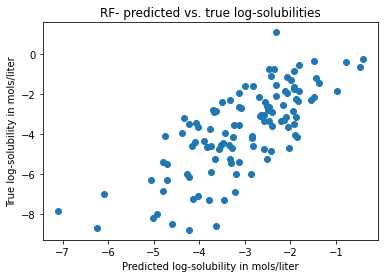

In [ ]:
task = "measured log solubility in mols per litre"
predicted_test = best_rf.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'RF- predicted vs. true log-solubilities')
plt.show()

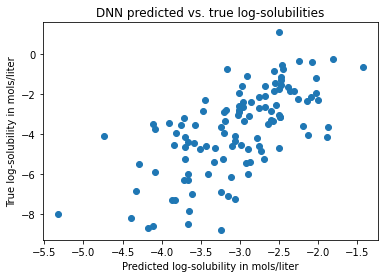

In [ ]:
task = "measured log solubility in mols per litre"
predicted_test = best_dnn.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'DNN predicted vs. true log-solubilities')
plt.show()

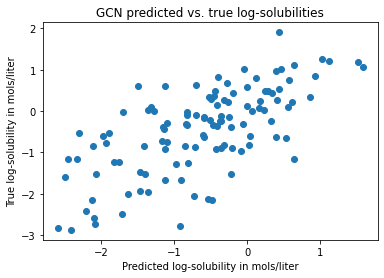

In [ ]:
predicted_test = best_gcn.predict(gcn_test_dataset)
true_test = gcn_test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'GCN predicted vs. true log-solubilities')
plt.show()